In [2]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.7 MB/s eta 0:00:00


In [3]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=3d53571638925e4d95c8a74d43fb34b531732317091cd71a1d305a0043bc2d70
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [4]:
!pip install -q transformers

In [5]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 6.6 MB/s eta 0:00:00


In [6]:
!pip install xgboost scikit-learn

In [7]:
from googleapiclient.discovery import build
import re
import emoji
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from langdetect import detect, DetectorFactory
from transformers import pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from datetime import datetime, timezone



Detecting sentiment of the comments using polarity scores.

In [ ]:
comments_df = pd.read_csv('/content/comments_df_sheet.csv',lineterminator='\n')

In [ ]:
comments_df.head()

,Unnamed: 0,channel_id,video_id,comment_text,comment_time
0,0,UCRTV5p4JsXV3YTdYpTJECRA,tFmQj7W4qlk,Can you provide a simple example calculation o...,2023-06-01T11:53:06Z
1,1,UCRTV5p4JsXV3YTdYpTJECRA,tFmQj7W4qlk,who chose this music :/,2022-12-27T16:17:47Z
2,2,UCRTV5p4JsXV3YTdYpTJECRA,tFmQj7W4qlk,Nice work. Just that the background music is s...,2022-12-02T06:19:11Z
3,3,UCRTV5p4JsXV3YTdYpTJECRA,tFmQj7W4qlk,For anyone interested for the music in the bac...,2022-11-09T08:45:29Z
4,4,UCRTV5p4JsXV3YTdYpTJECRA,tFmQj7W4qlk,Can you provide a simple example calculation o...,2023-06-01T11:53:06Z


In [ ]:
print(comments_df.shape)
comments_df = comments_df.drop('Unnamed: 0',axis=1)
comments_df = comments_df.drop_duplicates()
print(comments_df.shape)

(326153, 5)
(257042, 4)


In [ ]:
def sentiment_scores(comment):
    # Creating a SentimentIntensityAnalyzer object.
    sentiment_object = SentimentIntensityAnalyzer()
    sentiment_dict = sentiment_object.polarity_scores(comment)
    return sentiment_dict['compound']

In [ ]:
comments_df['polarity'] = comments_df.apply(lambda x :sentiment_scores(x['comment_text']),axis=1)

In [ ]:
#comments_df.to_csv('comments_polarity.csv',index=False)

Detect comments that are not in english.

In [ ]:
comments_df = pd.read_csv('comments_polarity.csv',lineterminator='\n')

In [ ]:
# Set seed to get consistent results from langdetect
DetectorFactory.seed = 0

def is_english(text):
  if not text or len(text.strip()) < 8:  # Check if text is empty or too short
      return False  # Optionally return False or a default language setting
  try:
      # Detect the language of the text
      language = detect(text)
      # Return True if the detected language is English
      return language == 'en'
  except:
      return False

In [ ]:
comments_df['lang'] = comments_df['comment_text'].apply(lambda x : is_english(x))

In [ ]:
comments_df.to_csv('comments_with_english.csv',index=False)

Remove from comments that are not in english from the data.

In [8]:
comments_df = pd.read_csv('comments_with_english.csv',lineterminator='\n')

In [9]:
comments_df['lang'].value_counts()

lang
True     226005
False     31037
Name: count, dtype: int64

In [10]:
comments_df = comments_df[comments_df['lang']==True]

Categorize sentiment into Positive, Negative, Neutral by categorizing polarity score

In [11]:
#comments_videos_summ = comments_df.groupby('video_id')['polarity'].agg([np.mean,np.min, np.max])
comments_df['polarity_cat'] = comments_df['polarity'].apply(lambda x : 'positive' if x >0.05 else ('negative' if x< -0.05 else 'neutral'))
comments_df_summ = comments_df.groupby(['video_id','polarity_cat'])['polarity'].count().reset_index()
comments_df_summ = comments_df_summ.pivot(index='video_id', columns='polarity_cat', values='polarity').reset_index()

In [12]:
comments_df_summ.rename(columns={'video_id':'Video_Id'},inplace=True)

Determine sentiment using pre-trained transformer model

In [ ]:
# sentiment_pipeline = pipeline("sentiment-analysis")
# data = ["I love you", "I hate you"]
# sentiment_pipeline(data)

In [ ]:
# comments_df['sentiment'] = comments_df.apply(lambda x :sentiment_pipeline(x['comment_text']),axis=1)

Data Processing




In [14]:
videos_df = pd.read_csv('/content/videos_df_sheet.csv')

In [15]:
# Function to convert duration string to minutes
def duration_to_minutes(duration_str):
    match = re.match(r"PT(\d+)M(\d+)S", duration_str)
    if match:
        minutes = int(match.group(1))
        seconds = int(match.group(2))
        total_minutes = minutes + seconds / 60  # Convert seconds to minutes
        return total_minutes
    else:
        return None  # Return None for invalid duration format

# Apply the function to the 'duration' column
videos_df['duration_minutes'] = videos_df['duration'].apply(duration_to_minutes)

In [16]:
videos_df.head()

,Unnamed: 0,Channel_id,Video_name,Video_Id,desc,pub_date,num_viewers,num_likes,num_fav,captions,duration,num_comments,duration_minutes
0,0,UCRTV5p4JsXV3YTdYpTJECRA,Basics of Designing Neural Network - Introduct...,lp4skE5U8Cs,This video explains the basics of designing ne...,2022-09-12T01:10:38Z,1505,9.0,0,True,PT24M33S,0.0,24.550000
1,1,UCRTV5p4JsXV3YTdYpTJECRA,NNC Tutorial : How to create dataset for image...,gAIzxNCl-kA,"In this video, we will explain how to create a...",2022-09-12T01:10:39Z,5815,43.0,0,True,PT10M33S,0.0,10.550000
2,2,UCRTV5p4JsXV3YTdYpTJECRA,NNC Tutorial : 5-minute design for Convolution...,T4VnimGjwF0,"In this video, we will explain how to build Co...",2022-09-12T01:10:39Z,929,7.0,0,True,PT8M12S,0.0,8.200000
3,3,UCRTV5p4JsXV3YTdYpTJECRA,NNC Tutorial : Neural Network Console for Begi...,3rmzZ231N_Q,This video explains from setting up to running...,2022-09-12T01:10:38Z,826,5.0,0,True,PT8M37S,0.0,8.616667
4,4,UCRTV5p4JsXV3YTdYpTJECRA,Downsizing Neural Networks by Quantization - I...,tFmQj7W4qlk,This video explains the quantization that real...,2022-09-12T01:10:38Z,4812,74.0,0,True,PT10M7S,7.0,10.116667


In [17]:
videos_df['pub_date'] = pd.to_datetime(videos_df['pub_date']).dt.tz_localize(None)

In [18]:
videos_df['days_since_published'] = datetime.today() - videos_df['pub_date']
videos_df['days_since_published'] = videos_df['days_since_published'].dt.days

In [19]:
videos_df = videos_df.drop('Unnamed: 0',axis=1)
videos_df.drop(['Video_name',	'desc','duration','num_comments','pub_date'],axis=1,inplace=True)
videos_df = videos_df.drop_duplicates()

In [20]:
videos_df['Channel_id'].nunique()

76

In [32]:
final_df = videos_df.merge(comments_df_summ, on='Video_Id',how='inner')
final_df.drop('Video_Id',axis=1,inplace=True)

In [33]:
final_df.head()

,Channel_id,num_viewers,num_likes,num_fav,captions,duration_minutes,days_since_published,negative,neutral,positive
0,UCRTV5p4JsXV3YTdYpTJECRA,4812,74.0,0,True,10.116667,589,1.0,1.0,2.0
1,UCRTV5p4JsXV3YTdYpTJECRA,7764,41.0,0,False,20.350000,589,3.0,1.0,1.0
2,UCRTV5p4JsXV3YTdYpTJECRA,8290,109.0,0,False,20.083333,1068,NaN,NaN,1.0
3,UCRTV5p4JsXV3YTdYpTJECRA,8966,109.0,0,False,22.600000,1076,NaN,NaN,1.0
4,UCRTV5p4JsXV3YTdYpTJECRA,6403,117.0,0,False,3.233333,1130,NaN,1.0,NaN


In [34]:
final_df.fillna(0,inplace=True)

<Axes: >

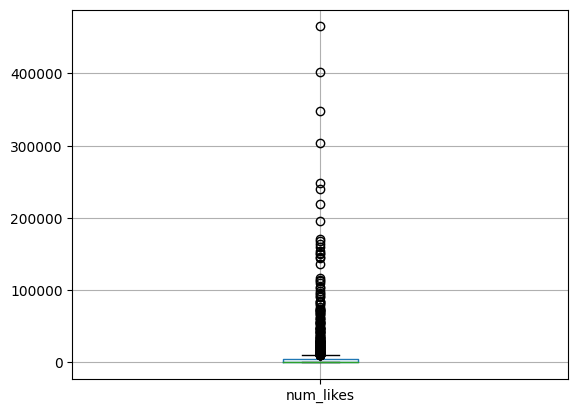

In [35]:
final_df[['num_likes']].boxplot()

array([[<Axes: title={'center': 'num_viewers'}>,
        <Axes: title={'center': 'num_likes'}>,
        <Axes: title={'center': 'num_fav'}>],
       [<Axes: title={'center': 'duration_minutes'}>,
        <Axes: title={'center': 'days_since_published'}>,
        <Axes: title={'center': 'negative'}>],
       [<Axes: title={'center': 'neutral'}>,
        <Axes: title={'center': 'positive'}>, <Axes: >]], dtype=object)

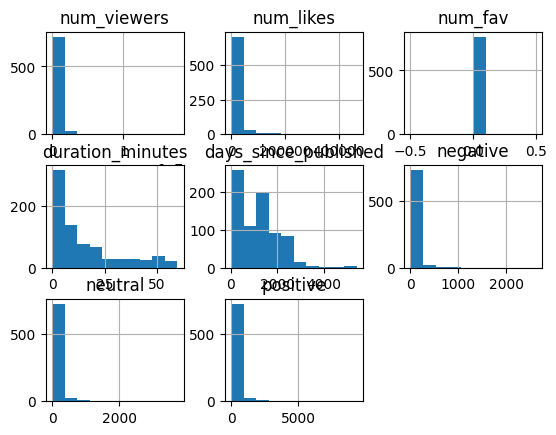

In [36]:
final_df.hist()

In [37]:
final_df['num_likes'].describe(percentiles=[0.90,0.95,0.99])

count       765.00000
mean      12870.54902
std       40057.03737
min           0.00000
50%         553.00000
90%       34119.00000
95%       72212.20000
99%      180001.16000
max      465216.00000
Name: num_likes, dtype: float64

In [38]:
final_df = final_df[final_df['num_likes'] <= 74031]

In [77]:
train,test = train_test_split(final_df, stratify = None)

In [78]:
y_train = train[['num_likes']]
x_train = train.drop('num_likes',axis=1)

In [79]:
y_test = test[['num_likes']]
x_test = test.drop('num_likes',axis=1)

In [80]:
cols = ['captions', 'Channel_id']
for col in cols:
  ohe = OneHotEncoder(drop='first',handle_unknown='ignore')
  ohe.fit(x_train[[col]])
  x_train[ohe.get_feature_names_out().tolist()] = ohe.transform(x_train[[col]]).toarray()
  x_test[ohe.get_feature_names_out().tolist()] = ohe.transform(x_test[[col]]).toarray()
  # Done with feature encoding, now dropping the actual categorical columns.
  x_train.drop(col,axis=1,inplace=True)
  x_test.drop(col,axis=1,inplace=True)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [81]:
x_train

,num_viewers,num_fav,duration_minutes,days_since_published,negative,neutral,positive,captions_True,Channel_id_UC4vAON9PsmKoyDGqftXWS-A,Channel_id_UC6-2NodomKW-ZFNs9Vuj8Mw,...,Channel_id_UCrBzGHKmGDcwLFnQGHJ3XYg,Channel_id_UCrp8k-nSuMKHM4sSUvlPdAw,Channel_id_UCtYLUTtgS3k1Fg4y5tAhLbw,Channel_id_UCtslD4DGH6PKyG_1gFAX7sg,Channel_id_UCtwKon9qMt5YLVgQt1tvJKg,Channel_id_UCv9hjmC-M77u3E8lUuO1-nQ,Channel_id_UCvd3QZ0zRpfQ3UAsEfAENwQ,Channel_id_UCw1Sl_jFYRl2gbkBLp7w4lg,Channel_id_UCwBhBDsqiQflTMLy2epbQVw,Channel_id_UCyp1gCHZJU_fGWFf2rtMkCg
753,83419,0,27.216667,2232,1.0,3.0,13.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
456,383,0,59.850000,562,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
701,595297,0,0.000000,403,17.0,42.0,132.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
332,522258,0,0.000000,1568,68.0,98.0,419.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
512,23389,0,38.866667,2113,3.0,8.0,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,669,0,0.000000,100,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
661,100,0,0.000000,191,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,11514,0,43.666667,539,1.0,3.0,13.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223,309554,0,0.000000,981,15.0,19.0,131.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
std_slr = StandardScaler()
std_slr.fit(x_train)
x_train_scaled = std_slr.transform(x_train)
x_test_scaled = std_slr.transform(x_test)

Random forest model to predict `Num_Likes`

In [83]:

param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at every split
    'max_depth': [None, 10, 20, 30],  # Maximum number of levels in tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}

# Initialize the RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42)

# Set up the GridSearchCV object
grid_search = GridSearchCV(estimator=forest_reg, param_grid=param_grid, cv=5,
                           scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)


In [84]:
# Perform the grid search
grid_search.fit(x_train_scaled, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_absolute_error', verbose=2)

In [85]:
# Best model after grid search
best_model = grid_search.best_estimator_


In [86]:
print(best_model)

RandomForestRegressor(max_features='auto', n_estimators=200, random_state=42)


In [87]:
# best_model = RandomForestRegressor(max_depth=10, max_features='auto', min_samples_leaf=4,
#                      n_estimators=200, random_state=42)
# best_model.fit(x_train, y_train)

In [88]:
y_pred = best_model.predict(x_test_scaled)
preds_df = pd.DataFrame()
preds_df['Num_likes'] = y_test
preds_df['Predicted_Num_likes'] = y_pred

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 20991666.95
Mean Absolute Error: 1678.65
R^2 Score: 0.91


In [91]:
preds_df.head()

,Num_likes,Predicted_Num_likes
302,42101.0,41037.495
572,450.0,605.600
192,286.0,397.410
736,1717.0,1835.420
594,8595.0,11032.925


Text(0.5, 1.0, 'Feature Importance of Random forest')

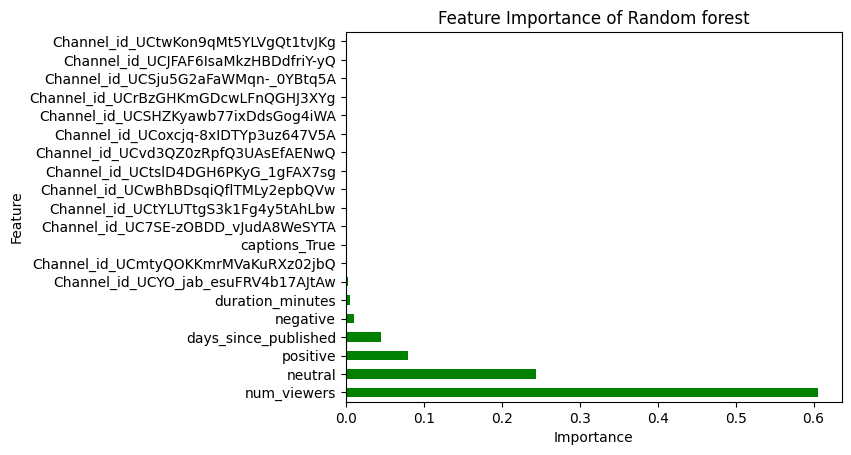

In [97]:
global_importances = pd.Series(best_model.feature_importances_, index=x_train.columns)
global_importances.sort_values(ascending=False, inplace=True)
global_importances_sub = global_importances.head(20)
global_importances_sub.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance of Random forest")

Light GBM model to predict `Num_Likes`

In [62]:
model = lgb.LGBMRegressor()

# Define the parameter grid
param_grid = {
    'num_leaves': [31, 61, 91],  # Increase for more complex models
    'max_depth': [-1, 10, 20],   # -1 means no limit
    'learning_rate': [0.01, 0.1, 0.2],  # Also known as shrinkage
    'n_estimators': [100, 200, 300]
}

# Setup the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3,
                           scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)

# Perform the grid search
grid_search.fit(x_train, y_train)

# Find the best model
best_model_lgbm = grid_search.best_estimator_

# Predict using the best model
predictions = best_model_lgbm.predict(x_test)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 546, number of used features: 16
[LightGBM] [Info] Start training from score 5742.558608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [63]:
y_pred = best_model_lgbm.predict(x_test)

preds_df = pd.DataFrame()
preds_df['Num_likes'] = y_test
preds_df['Predicted_Num_likes'] = y_pred

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Mean Squared Error: 11252867.20
Mean Absolute Error: 1333.20
R^2 Score: 0.94


In [64]:
preds_df.head()

,Num_likes,Predicted_Num_likes
589,2271.0,2811.401852
720,1081.0,1196.680802
374,516.0,587.699274
478,401.0,519.800037
574,1692.0,1490.263637


XG Boost model to predict `Num_Likes`

In [65]:
model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],  # Depth of each tree
    'n_estimators': [50, 100, 150],  # Number of trees to build
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage used to prevent overfitting
    'subsample': [0.7, 0.8, 0.9],  # Subsample ratio of the training instances
    'colsample_bytree': [0.7, 0.8, 0.9]  # Subsample ratio of columns when constructing each tree
}

# Set up the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3,
                           scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)

# Perform the grid search
grid_search.fit(x_train, y_train)

# Best model after hyperparameter tuning
best_model_xgb = grid_search.best_estimator_

# Predict on the testing set
predictions = best_model_xgb.predict(x_test)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


In [66]:
y_pred = best_model_xgb.predict(x_test)
preds_df = pd.DataFrame()
preds_df['Num_likes'] = y_test
preds_df['Predicted_Num_likes'] = y_pred

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 8313198.14
Mean Absolute Error: 1124.83
R^2 Score: 0.95


In [67]:
preds_df.head()

,Num_likes,Predicted_Num_likes
589,2271.0,4322.191895
720,1081.0,1157.703979
374,516.0,571.750977
478,401.0,442.534393
574,1692.0,1679.945557
